# Predicting Diabetes with Machine Learning Models

In this notebook, we will do exploratory data analysis, cleaning and preprocess patient data classified if they have diabetes. We want to split this data into train and test sets to assess a potential ML predictor for patients having diabetes.

## 1. Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

df = pd.read_csv('datasets/diabetes.csv')
df.head()

,pregnancies,glucose,diastolic,triceps,insulin,bmi,dpf,age,diabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pregnancies  768 non-null    int64  
 1   glucose      768 non-null    int64  
 2   diastolic    768 non-null    int64  
 3   triceps      768 non-null    int64  
 4   insulin      768 non-null    int64  
 5   bmi          768 non-null    float64
 6   dpf          768 non-null    float64
 7   age          768 non-null    int64  
 8   diabetes     768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [44]:
df.describe()

,pregnancies,glucose,diastolic,triceps,insulin,bmi,dpf,age,diabetes
count,768.000000,768.000000,768.000000,541.000000,394.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,29.153420,155.548223,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,10.476982,118.775855,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,7.000000,14.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,22.000000,76.250000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,36.000000,190.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Although there are no NaN values, there are zero values in triceps and insulin. We will replace these by the average values of the non-zero observations via an imputer in a ML pipeline. But first let us replace zeros by NaNs, as those are easier to handle with pandas.

In [3]:
for col in ['insulin', 'triceps']:
    df[col].replace(0, np.nan, inplace=True)
df.head()

,pregnancies,glucose,diastolic,triceps,insulin,bmi,dpf,age,diabetes
0,6,148,72,35.0,NaN,33.6,0.627,50,1
1,1,85,66,29.0,NaN,26.6,0.351,31,0
2,8,183,64,NaN,NaN,23.3,0.672,32,1
3,1,89,66,23.0,94.0,28.1,0.167,21,0
4,0,137,40,35.0,168.0,43.1,2.288,33,1


Could we drop all NaNs? No, because we miss too many observations!

In [5]:
df_drop = df.dropna()
print("{} missed observations out of {}".format(df.shape[0] - df_drop.shape[0], df.shape[0]))

374 missed observations out of 768


We can replace NaNs by the mean value of each column:

In [6]:
mean_insulin = df_drop.insulin.mean()
mean_triceps = df_drop.triceps.mean()
print(mean_insulin, mean_triceps)

df_impute = df.replace({'insulin': {np.nan : mean_insulin}, 'triceps' : {np.nan : mean_triceps}})
df_impute.head()

155.5482233502538 29.106598984771573


,pregnancies,glucose,diastolic,triceps,insulin,bmi,dpf,age,diabetes
0,6,148,72,35.000000,155.548223,33.6,0.627,50,1
1,1,85,66,29.000000,155.548223,26.6,0.351,31,0
2,8,183,64,29.106599,155.548223,23.3,0.672,32,1
3,1,89,66,23.000000,94.000000,28.1,0.167,21,0
4,0,137,40,35.000000,168.000000,43.1,2.288,33,1


We can now make some exploratory plots

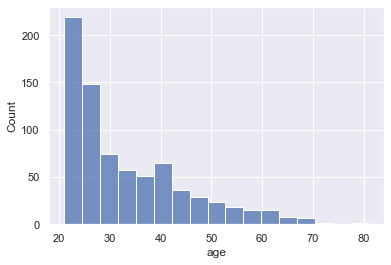

In [7]:
sns.histplot(x='age', data=df_impute);

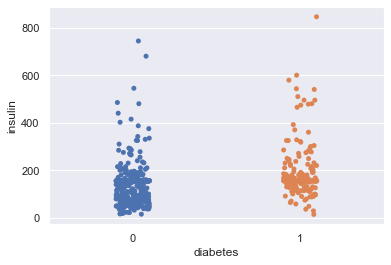

In [123]:
sns.stripplot(x='diabetes', y='insulin', data=df_impute);

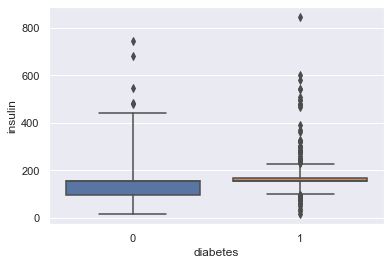

In [9]:
sns.boxplot(x='diabetes', y='insulin', data=df_impute, whis=5);

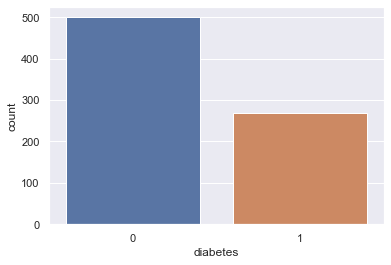

In [147]:
sns.countplot(x='diabetes', data=df);

## 2. Machine Learning Prediction

Now let us start our ML pipeline using scikit-learn. This will involve 3 steps: imputation, scaling, and training. We train the data using Logistic Regression, and use GridSearchCV to do hyperparameter estimation and cross-validation.

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# Define input data with target = diabetes
X = df.drop(['diabetes'], axis=1).values
y = df.diabetes.values

# Define the pipeline steps and call it
steps = [('imp', SimpleImputer(missing_values=np.nan, strategy='mean')),\
         ('scale', StandardScaler()), ('logreg', LogisticRegression())]
pipeline = Pipeline(steps)

# Specify the hyperparameter space
max_iter = [100, 200, 300]
tol = [0.1, 0.01, 0.001]
c_space = np.logspace(-5, 8, 15)
#parameters = {'logreg__max_iter': max_iter, 'logreg__tol':tol, 'logreg__C': c_space} #, 'logreg__penalty': ['l1', 'l2']
parameters = {'logreg__tol': tol, 'logreg__C': c_space}

# Split Train and Test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Create GridSearchCV object
logreg_grid_cv = GridSearchCV(pipeline, parameters, cv=5)

# Fit to the training set
logreg_grid_cv.fit(X_train, y_train)

# Predict
y_pred = logreg_grid_cv.predict(X_test)

# Compute and print the metrics
r2 = logreg_grid_cv.score(X_test, y_test)
print("Tuned LogisticRegression Parameters: {}".format(logreg_grid_cv.best_params_))
print("Tuned LogisticRegression R squared: {}".format(r2))
print("\n", classification_report(y_test, y_pred))

Tuned LogisticRegression Parameters: {'logreg__C': 0.05179474679231213, 'logreg__tol': 0.1}
Tuned LogisticRegression R squared: 0.7532467532467533

               precision    recall  f1-score   support

           0       0.80      0.83      0.82       206
           1       0.64      0.59      0.61       102

    accuracy                           0.75       308
   macro avg       0.72      0.71      0.72       308
weighted avg       0.75      0.75      0.75       308



In [153]:
logreg_grid_cv.best_score_

0.7652173913043477

The confusion matrix is given by

|             | predicted: real | predicted: spam |
|-------------|-----------------|-----------------|
| actual real | True Negatives  | False Positives |
| actual spam | False Negatives | True positives  |

In [18]:
cfs = confusion_matrix(y_test, y_pred)
print(cfs)

[[172  34]
 [ 42  60]]


From this we can compute the Sensitivity, or percentage of True Positives (tp), and Specificity, or percentage of True Negatives (tn), of our test

$$ \text{Sensitivity} = \frac{tp}{tp + fn}, \quad \text{Specificity} = \frac{tn}{tn + fp} $$

In [19]:
sens = cfs[1,1]/(cfs[1,1]+cfs[1,0])
spec = cfs[0,0]/(cfs[0,0]+cfs[0,1])
print("The Sensitivity is {}".format(100*sens), "\nThe Specificity is {}%".format(100*spec))

The Sensitivity is 58.82352941176471 
The Specificity is 83.49514563106796%


These match the Recall values in the classification report.

Let us compute the ROC curve and the area under the curve.

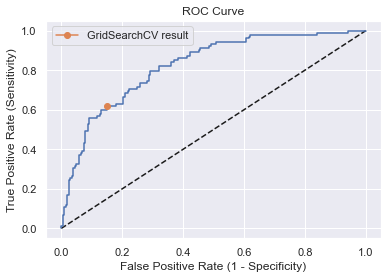

Area under the curve (AUC) = 0.8240053302874548


In [163]:
from sklearn.metrics import roc_curve, roc_auc_score

# Compute predicted probabilities
y_pred_prob = logreg_grid_cv.predict_proba(X_test)[:,1]

# Generate ROC curve values: false positive ratio, true positive ratio, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.plot(1-spec, sens, marker='o', label='GridSearchCV result')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve')
plt.legend()
plt.show()

print("Area under the curve (AUC) =", roc_auc_score(y_test, y_pred_prob))

## Next steps
- Test different models.
- Use an Ensemble technique.
- Try a Boosting technique.
- See Datacamp courses.